In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms #transforms=transform data and models=Alexnet & ...
from urllib import *
url = './data'

In [2]:
#transform = transforms.Compose([transforms.ToTensor(),
 #                             transforms.Normalize((0.5 , 0.5 ,0.5) , ( 0.5 , 0.5,0.5))
  #                             ]) #3 0.5 for 3 channels of our image
                                  # first is for variance and second is for average
    

    
transform  = transforms.Compose([transforms.Resize((28,28)),transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) #as we have one cahnnel
    
#each data importet from MNIST is gray scale and 28 by 28

training_dataset = datasets.MNIST(root = './data', train=True , download=True , transform=transform) #downloding dataset
#with transform we mean to apply normalization to our data downloaded
training_dataset

validation_dataset = datasets.MNIST(root = './data', train=False , download=True , transform=transform)
validation_dataset


#training loader actually load our images so then we can use in our code
#it is what we use for batching
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
#shuffing helps to avoid local minimums. subset of data changes in every iteration in shuffle

validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=100, shuffle=False)
#there is no need to shuffle

In [3]:
# changing images from tensor to numpy array

def TN_convert(tensor): #giving a tensor to transform it to numpy array
    image = tensor.clone().detach().numpy() #clone is for copying tensor first and then apply some other functions to it
    image = image.transpose(1, 2, 0) #this makes our image to transform from 1,28,28 to 28,28,1
    print(image.shape)
    
    #after all we denormalize our images according to normalization process and constants
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) #as from our equation for normalization
    #this normalization take back our arrays from [0, 1] to [-1, 1]
    
    image = image.clip(0,1) #to limit values between 0 and 1 #why???
    return image

(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


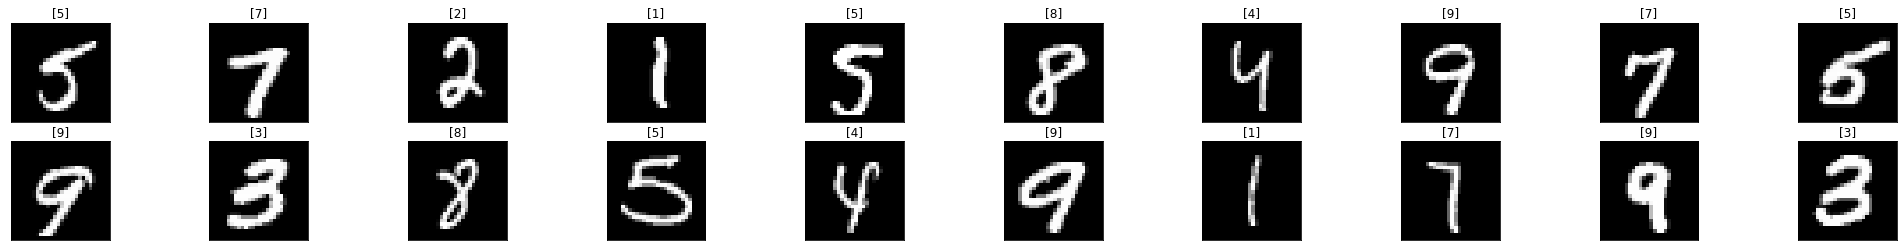

In [4]:
#showing dataset

dataiter = iter(training_loader) #it creates an obj that allows us to go iteratble training_loader one element at a time

#then we want to access one element at a time 
images , labels = dataiter.next() #it grabs the first batch of our training data

fig = plt.figure(figsize=(35,4))#width and height of the figure


for idx in np.arange(20): #20 should be consistent with 2 and 10 in below
    ax = fig.add_subplot(2, 10, idx+1, xticks=[],yticks=[])#20 images will be ploted.... 2=number_of_rows  10=number_of_columns 
    plt.imshow(TN_convert(images[idx]))#we access to image number idx....it gives back a tensor, so we use TN_convert
    
    #we give every images title, it's corresponding label
    ax.set_title([labels[idx].item()])

In [5]:
#we now use this pre labeled dataset to train our network

In [6]:
class classifier(nn.Module):
    def __init__(self, input_size, H1, H2, output_size): #2 layers
        super().__init__()
        self.Linear1 = nn.Linear(input_size , H1)
        self.Linear2 = nn.Linear(H1 , H2)
        self.Linear3 = nn.Linear(H2 , output_size)
    
    def forward(self, x):
        x = F.relu(self.Linear1(x)) #nn.ReLU
        x = F.relu(self.Linear2(x))
        x = self.Linear3(x) #from that on the last layer corresponding class will be allocated
        return x

In [7]:
#making an object in order to train it base on our dataset

model = classifier(784,125,65,10)#784=28*28 which is our image that should be flatted in order to be trained in neural network
# 125 and 65 is guessed

model

classifier(
  (Linear1): Linear(in_features=784, out_features=125, bias=True)
  (Linear2): Linear(in_features=125, out_features=65, bias=True)
  (Linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [8]:
#training

criterion = nn.CrossEntropyLoss()#instead of BCE or MSE
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #adam and softmax are for nonlinear and sigmoid is linear

In [9]:
epochs = 10
train_loss_history = []
train_correct_history = []
validation_loss_history = []
validation_correct_history = []

#as we are having batches we need to for loops
for j in range(epochs):
    
    train_running_loss = 0.0 #loss determination for every batch
    train_running_correct = 0.0 #correct determination for every batch
    validation_running_loss = 0.0
    validation_running_correct = 0.0
    
    
    for inputs , labels in training_loader: #why and how 2 items???
        #inputs that will be fed to our model
        inputs = inputs.view(inputs.shape[0] , -1) #[1,28,28]... inputs.shape[0] set first column as it is and flat others to 1
        #so here we have [1, 784]
        
        #outputs-- from forward function of model we could obtain corresponding class
        outputs = model(inputs)
        
        loss = criterion(outputs , labels) #loss-- difference between labels of images and our output determination
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #for every 10 class of our model we want to turn the maximum score value wich identifies class of each image
        #we use max for determining correct classifications
        _ , preds =  torch.max(outputs,1) #a tuple is returned 
     
        train_running_loss += loss.item() #(list of all loss calculations for every epoch)false --- it is a number not a list
        train_running_correct += torch.sum(preds == labels.data) #list of all correct calculations for every epoch---number not list
        
        
        
    else: #whenever we took all iterations in inner loop else will be called
        with torch.no_grad():#to save memory
            for validation_inputs , validation_labels in validation_loader:
                validation_inputs = validation_inputs.view(validation_inputs.shape[0] , -1)
                validation_outputs = model(validation_inputs)
                validation_loss = criterion(validation_outputs , validation_labels)

            
            _ , validation_preds =  torch.max(validation_outputs,1)
            validation_running_loss += loss.item()
            validation_running_correct += torch.sum(validation_preds == validation_labels.data)
        
        
        epoch_loss = train_running_loss/len(training_loader.dataset) #calculated average loss for every entire epoch 
        epoch_acc = train_running_correct.float()/len(training_loader.dataset)#calculated average loss for every entire epoch
        #.dataset is for gainig percentage
        
        train_loss_history.append(epoch_loss) #we will have list of all average losses in every epoch
        train_correct_history.append(epoch_acc)
        print('epoch: ', (j+1))
        print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
        
        
        validation_epoch_loss = validation_running_loss/len(validation_loader)
        validation_epoch_acc = validation_running_correct.float()/len(validation_loader)
        validation_loss_history.append(validation_epoch_loss)
        validation_correct_history.append(validation_epoch_acc)
        print('validation loss: {:.4f}, acc {:.4f} '.format(validation_epoch_loss, validation_epoch_acc.item()))
        
        
        #why somewhere it works well with .dataset anda somewhere not???
        

epoch:  1
training loss: 0.0037, acc 0.8874 
validation loss: 0.0021, acc 0.8900 
epoch:  2
training loss: 0.0022, acc 0.9333 
validation loss: 0.0024, acc 0.9200 
epoch:  3
training loss: 0.0020, acc 0.9410 
validation loss: 0.0025, acc 0.9200 
epoch:  4
training loss: 0.0019, acc 0.9462 
validation loss: 0.0018, acc 0.8800 
epoch:  5
training loss: 0.0018, acc 0.9477 
validation loss: 0.0009, acc 0.8900 
epoch:  6
training loss: 0.0018, acc 0.9505 
validation loss: 0.0022, acc 0.8700 
epoch:  7
training loss: 0.0017, acc 0.9516 
validation loss: 0.0009, acc 0.8700 
epoch:  8
training loss: 0.0017, acc 0.9524 
validation loss: 0.0019, acc 0.9100 
epoch:  9
training loss: 0.0016, acc 0.9560 
validation loss: 0.0019, acc 0.9500 
epoch:  10
training loss: 0.0017, acc 0.9527 
validation loss: 0.0022, acc 0.9300 


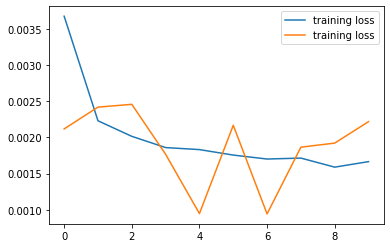

In [10]:
plt.plot(train_loss_history, label='training loss')
plt.plot(validation_loss_history, label='training loss')
plt.legend()

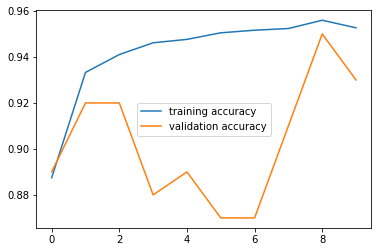

In [11]:
plt.plot(train_correct_history, label = 'training accuracy')
plt.plot(validation_correct_history, label='validation accuracy')
plt.legend()

In [12]:
import PIL.ImageOps

In [2]:
#Testing
#import requests
#from PIL import Image

#url1 = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
#response = requests.get(url1, stream = True)
#img = Image.open(response.raw)
#plt.imshow(img)

(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


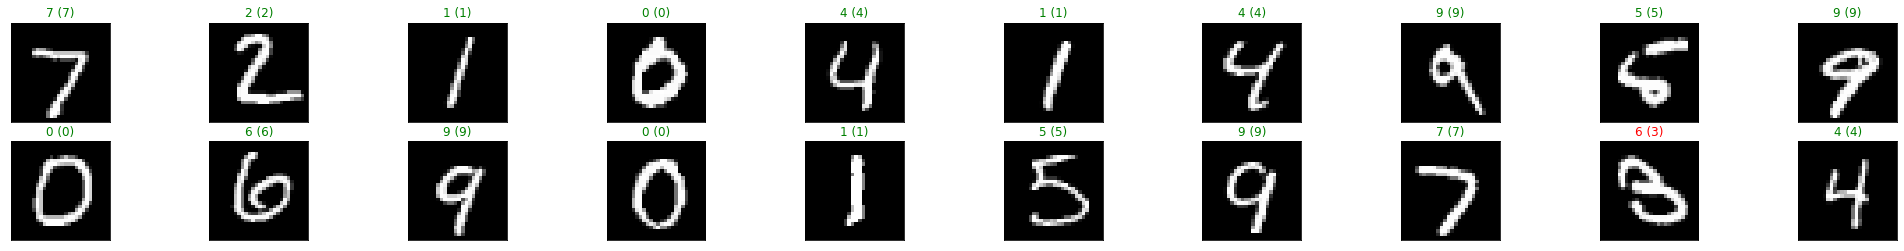

In [14]:
#test
dataiter = iter(validation_loader) 
images , labels = dataiter.next()
images_ = images.view(images.shape[0], -1)
output = model(images_)
_, preds = torch.max(output,1)
fig = plt.figure(figsize=(35,4))

for idx in np.arange(20): 
    ax = fig.add_subplot(2, 10, idx+1, xticks=[],yticks=[]) 
    plt.imshow(TN_convert(images[idx]))
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))